## Importing libraries

In [1]:
import pandas as pd
import json
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

### Loading review data

In [3]:
review_path = 'review.json'

review_sample = []
with open(review_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= 60000:
            break
        try:
            review_sample.append(json.loads(line))
        except json.JSONDecodeError:
            continue  

review_df = pd.DataFrame(review_sample)
print(review_df.columns)

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')


In [4]:
review_df = review_df[[
    'review_id',
    'user_id',
    'business_id',
    'stars',
    'text',
    'useful',
    'funny',
    'cool',
    'date'
]]

In [5]:
review_df

,review_id,user_id,business_id,stars,text,useful,funny,cool,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",0,0,0,2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,1,0,1,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,0,0,0,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",1,0,1,2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,1,0,1,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
59995,iyYZRxFHsHlwV4aVMZiHOQ,Z_6lcQVPWJ7Es0M18E55yQ,ST6l2UHi9lnr2Ktx5yTOTw,5.0,This was such a fun and interactive event. Yel...,0,0,0,2018-07-19 18:30:00
59996,xiGasxxaY9kZPAZSB5XPXQ,ZnzpvxOa7eiLESrebeufJQ,WF_KgJ1tuhz6rMI4_xZSRw,5.0,"Great bar, great staff, great time. We brought...",2,0,2,2017-01-06 03:19:32
59997,wCegJqMUj5l3JUV_UJwsaQ,ZnJ9oiCvKDhyEwPET53kFg,UCMSWPqzXjd7QHq7v8PJjQ,3.0,It's ok. Definitely over hyped. It's a step ab...,0,0,0,2018-03-25 19:00:05
59998,wXeaOxHMM4T_Fb99_Pm9og,rixcC0Hmoi8MoqavPfcaDg,0wQCEcpZ57TmTm6EmEDsIw,3.0,I also used the coupon in this app for the fre...,0,0,0,2017-07-30 23:34:56


### Loading user data

In [6]:
user_path = 'user.json'
user_data = []

user_id = set(review_df['user_id'])

with open(user_path, 'r', encoding='utf-8') as f:
    for line in f:
        record = json.loads(line)
        if record['user_id'] in user_id:
            user_data.append(record)

user_df = pd.DataFrame(user_data)

In [7]:
user_df = user_df[[
    'user_id',
    'name',
    'review_count',
    'yelping_since',
    'useful',
    'funny',
    'cool',
    'elite',
    'friends',
    'fans',
    'average_stars',
    'compliment_hot',
    'compliment_cool'
]]

In [8]:
user_df

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_cool
0,E9kcWJdJUHuTKfQurPljwA,Mike,358,2008-12-11 22:11:56,399,102,143,,"y2GyxJF5VQWohxgw_GR7Jw, 0NRn4eY3JWN0IFqvOSa5gA...",23,3.73,4,12
1,AUi8MPWJ0mLkMfwbui27lg,John,109,2010-01-07 18:32:04,154,20,23,,"gy5fWeSv3Gamuq9Ox4MV4g, lMr3LWU6kPFLTmCpDkACxg...",4,3.40,0,3
2,vVukUtqoLF5BvH_VtQFNoA,Charlene,37,2011-01-29 17:18:59,63,3,27,,"zkK6c9BcDyqreU0fqI_JLQ, opI1hhhFqElB6pptNH9ZqA...",4,4.51,4,0
3,fJZO_skqpnhk1kvomI4dmA,Jennifer,25,2008-07-14 16:01:36,29,2,19,,"hJiJzw6obCmbGAfwrTkavQ, EMJV9rib660I4RpMsbzWbg...",1,4.15,0,2
4,OlJ9vcVFB1iEKcZO-MS3cQ,Joz Joz Joz,348,2006-03-03 08:10:12,2063,1260,1537,"2006,2007,2008,2009,2010,2011,2012","iBeN7TtSJrq-dLwj-EevFw, oSN3M4_WKdlTsnpgqPDiBg...",116,3.93,319,462
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50535,Sr6vAlsj9ftWg4g2xXGxqQ,Courtney,5,2014-06-13 02:43:54,3,0,1,,None,0,4.00,0,0
50536,mwOEZxlTltcT64YV3loWpg,Terry,3,2016-06-26 13:19:53,3,0,0,,None,0,3.67,0,0
50537,ikL5cPkqqi1JNsUfTC6BWg,Jamie,5,2014-12-03 16:53:25,0,0,0,,None,0,1.80,0,0
50538,k5Y24bZA8q46genYh3BCfg,Peter,1,2012-12-27 22:49:48,0,0,0,,None,0,5.00,0,0


### merging user and their review dfs toghther

In [9]:
merged_df = review_df.merge(user_df, on='user_id', how='inner', suffixes=('_review', '_user'))
merged_df

,review_id,user_id,business_id,stars,text,useful_review,funny_review,cool_review,date,name,review_count,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_cool
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",0,0,0,2018-07-07 22:09:11,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06,0,1
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,1,0,1,2012-01-03 15:28:18,Erin,10,2011-03-07 19:45:15,6,1,2,,"7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTDQ...",0,4.30,0,0
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,0,0,0,2014-02-05 20:30:30,Debra,1332,2012-09-04 23:57:25,1660,675,1300,"2014,2015,2016,2017,2018,2019,20,20,2021","IaqwLtG5Se-kt_MHBOalag, tBpyi-tXOYQlkjtQKPd5aw...",58,4.69,16,86
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",1,0,1,2015-01-04 00:01:03,Kyle,9,2014-01-17 19:20:57,1,0,1,,None,0,4.78,0,0
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,1,0,1,2017-01-14 20:54:15,Sophia,126,2008-04-17 13:39:54,74,20,12,,None,0,2.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,iyYZRxFHsHlwV4aVMZiHOQ,Z_6lcQVPWJ7Es0M18E55yQ,ST6l2UHi9lnr2Ktx5yTOTw,5.0,This was such a fun and interactive event. Yel...,0,0,0,2018-07-19 18:30:00,Laura,1,2017-11-11 20:35:30,0,0,0,,"vHc-UrI9yfL_pnnc6nJtyQ, fvB24qE5UVKuGH5aDAqcVQ",1,5.00,0,0
59996,xiGasxxaY9kZPAZSB5XPXQ,ZnzpvxOa7eiLESrebeufJQ,WF_KgJ1tuhz6rMI4_xZSRw,5.0,"Great bar, great staff, great time. We brought...",2,0,2,2017-01-06 03:19:32,Chametria,133,2014-09-26 16:09:29,186,45,96,"2015,2016,2017","tp8wzuxL1RrSwniJkRUJ8A, L04Kmah0vn1B_gvR02uW6A...",9,3.91,9,13
59997,wCegJqMUj5l3JUV_UJwsaQ,ZnJ9oiCvKDhyEwPET53kFg,UCMSWPqzXjd7QHq7v8PJjQ,3.0,It's ok. Definitely over hyped. It's a step ab...,0,0,0,2018-03-25 19:00:05,L.a.,10,2016-08-03 16:22:26,2,0,0,,None,0,3.60,0,0
59998,wXeaOxHMM4T_Fb99_Pm9og,rixcC0Hmoi8MoqavPfcaDg,0wQCEcpZ57TmTm6EmEDsIw,3.0,I also used the coupon in this app for the fre...,0,0,0,2017-07-30 23:34:56,David,58,2013-12-16 17:17:33,48,15,3,,"V3XYG1zKuW8VUBNtjacoxA, yrcYZM64W8grrHQep6feEg...",1,3.37,0,0


### data cleaning

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

merged_df['clean_text'] = merged_df['text'].apply(clean_text)
merged_df.head()

,review_id,user_id,business_id,stars,text,useful_review,funny_review,cool_review,date,name,review_count,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_cool,clean_text
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",0,0,0,2018-07-07 22:09:11,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06,0,1,if you decide to eat here just be aware it is ...
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,1,0,1,2012-01-03 15:28:18,Erin,10,2011-03-07 19:45:15,6,1,2,,"7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTDQ...",0,4.30,0,0,ive taken a lot of spin classes over the years...
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,0,0,0,2014-02-05 20:30:30,Debra,1332,2012-09-04 23:57:25,1660,675,1300,"2014,2015,2016,2017,2018,2019,20,20,2021","IaqwLtG5Se-kt_MHBOalag, tBpyi-tXOYQlkjtQKPd5aw...",58,4.69,16,86,family diner had the buffet eclectic assortmen...
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",1,0,1,2015-01-04 00:01:03,Kyle,9,2014-01-17 19:20:57,1,0,1,,None,0,4.78,0,0,wow yummy different delicious our favorite is ...
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,1,0,1,2017-01-14 20:54:15,Sophia,126,2008-04-17 13:39:54,74,20,12,,None,0,2.97,0,0,cute interior and owner gave us tour of upcomi...


### sentiment analysis

In [11]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Alip\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = merged_df['clean_text'].apply(sid.polarity_scores)
sentiment_df = sentiment_scores.apply(pd.Series)
merged_df = pd.concat([merged_df, sentiment_df], axis=1)

merged_df

,review_id,user_id,business_id,stars,text,useful_review,funny_review,cool_review,date,name,review_count,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_cool,clean_text,neg,neu,pos,compound,neg,neu,pos,compound
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",0,0,0,2018-07-07 22:09:11,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06,0,1,if you decide to eat here just be aware it is ...,0.000,0.890,0.110,0.8491,0.000,0.890,0.110,0.8491
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,1,0,1,2012-01-03 15:28:18,Erin,10,2011-03-07 19:45:15,6,1,2,,"7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTDQ...",0,4.30,0,0,ive taken a lot of spin classes over the years...,0.050,0.707,0.243,0.9855,0.050,0.707,0.243,0.9855
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,0,0,0,2014-02-05 20:30:30,Debra,1332,2012-09-04 23:57:25,1660,675,1300,"2014,2015,2016,2017,2018,2019,20,20,2021","IaqwLtG5Se-kt_MHBOalag, tBpyi-tXOYQlkjtQKPd5aw...",58,4.69,16,86,family diner had the buffet eclectic assortmen...,0.035,0.709,0.257,0.9201,0.035,0.709,0.257,0.9201
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",1,0,1,2015-01-04 00:01:03,Kyle,9,2014-01-17 19:20:57,1,0,1,,None,0,4.78,0,0,wow yummy different delicious our favorite is ...,0.000,0.674,0.326,0.9509,0.000,0.674,0.326,0.9509
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,1,0,1,2017-01-14 20:54:15,Sophia,126,2008-04-17 13:39:54,74,20,12,,None,0,2.97,0,0,cute interior and owner gave us tour of upcomi...,0.017,0.710,0.272,0.9798,0.017,0.710,0.272,0.9798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,iyYZRxFHsHlwV4aVMZiHOQ,Z_6lcQVPWJ7Es0M18E55yQ,ST6l2UHi9lnr2Ktx5yTOTw,5.0,This was such a fun and interactive event. Yel...,0,0,0,2018-07-19 18:30:00,Laura,1,2017-11-11 20:35:30,0,0,0,,"vHc-UrI9yfL_pnnc6nJtyQ, fvB24qE5UVKuGH5aDAqcVQ",1,5.00,0,0,this was such a fun and interactive event yelp...,0.058,0.634,0.307,0.9490,0.058,0.634,0.307,0.9490
59996,xiGasxxaY9kZPAZSB5XPXQ,ZnzpvxOa7eiLESrebeufJQ,WF_KgJ1tuhz6rMI4_xZSRw,5.0,"Great bar, great staff, great time. We brought...",2,0,2,2017-01-06 03:19:32,Chametria,133,2014-09-26 16:09:29,186,45,96,"2015,2016,2017","tp8wzuxL1RrSwniJkRUJ8A, L04Kmah0vn1B_gvR02uW6A...",9,3.91,9,13,great bar great staff great time we brought th...,0.000,0.545,0.455,0.9860,0.000,0.545,0.455,0.9860
59997,wCegJqMUj5l3JUV_UJwsaQ,ZnJ9oiCvKDhyEwPET53kFg,UCMSWPqzXjd7QHq7v8PJjQ,3.0,It's ok. Definitely over hyped. It's a step ab...,0,0,0,2018-03-25 19:00:05,L.a.,10,2016-08-03 16:22:26,2,0,0,,None,0,3.60,0,0,its ok definitely over hyped its a step above ...,0.000,0.790,0.210,0.3506,0.000,0.790,0.210,0.3506
59998,wXeaOxHMM4T_Fb99_Pm9og,rixcC0Hmoi8MoqavPfcaDg,0wQCEcpZ57TmTm6EmEDsIw,3.0,I also used the coupon in this app for the fre...,0,0,0,2017-07-30 23:34:56,David,58,2013-12-16 17:17:33,48,15,3,,"V3XYG1zKuW8VUBNtjacoxA, yrcYZM64W8grrHQep6feEg...",1,3.37,0,0,i also used the coupon in this app for the fre...,0.036,0.834,0.130,0.9269,0.036,0.834,0.130,0.9269


### Friend list Graph creating nodes and edges

In [20]:
merged_df['friends_list'] = merged_df['friends'].apply(lambda x: x.split(', ') if isinstance(x, str) and x else [])

valid_users = set(merged_df['user_id'])

G = nx.Graph()
G.add_nodes_from(valid_users)

edges = [
    (user, friend)
    for user, friends in zip(merged_df['user_id'], merged_df['friends_list'])
    for friend in friends
    if friend in valid_users
]
G.add_edges_from(edges)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

degree_dict = dict(G.degree())
merged_df['network_degree'] = merged_df['user_id'].map(degree_dict).fillna(0).astype(int)

Number of nodes: 50540
Number of edges: 92820


In [21]:
merged_df.head()

,review_id,user_id,business_id,stars,text,useful_review,funny_review,cool_review,date,name,review_count,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_cool,clean_text,neg,neu,pos,compound,neg,neu,pos,compound,friends_list,network_degree
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",0,0,0,2018-07-07 22:09:11,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06,0,1,if you decide to eat here just be aware it is ...,0.000,0.890,0.110,0.8491,0.000,0.890,0.110,0.8491,"[DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWs...",1
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,1,0,1,2012-01-03 15:28:18,Erin,10,2011-03-07 19:45:15,6,1,2,,"7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTDQ...",0,4.30,0,0,ive taken a lot of spin classes over the years...,0.050,0.707,0.243,0.9855,0.050,0.707,0.243,0.9855,"[7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTD...",2
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,0,0,0,2014-02-05 20:30:30,Debra,1332,2012-09-04 23:57:25,1660,675,1300,"2014,2015,2016,2017,2018,2019,20,20,2021","IaqwLtG5Se-kt_MHBOalag, tBpyi-tXOYQlkjtQKPd5aw...",58,4.69,16,86,family diner had the buffet eclectic assortmen...,0.035,0.709,0.257,0.9201,0.035,0.709,0.257,0.9201,"[IaqwLtG5Se-kt_MHBOalag, tBpyi-tXOYQlkjtQKPd5a...",4
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",1,0,1,2015-01-04 00:01:03,Kyle,9,2014-01-17 19:20:57,1,0,1,,None,0,4.78,0,0,wow yummy different delicious our favorite is ...,0.000,0.674,0.326,0.9509,0.000,0.674,0.326,0.9509,[None],0
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,1,0,1,2017-01-14 20:54:15,Sophia,126,2008-04-17 13:39:54,74,20,12,,None,0,2.97,0,0,cute interior and owner gave us tour of upcomi...,0.017,0.710,0.272,0.9798,0.017,0.710,0.272,0.9798,[None],0


### Subgraph of the network

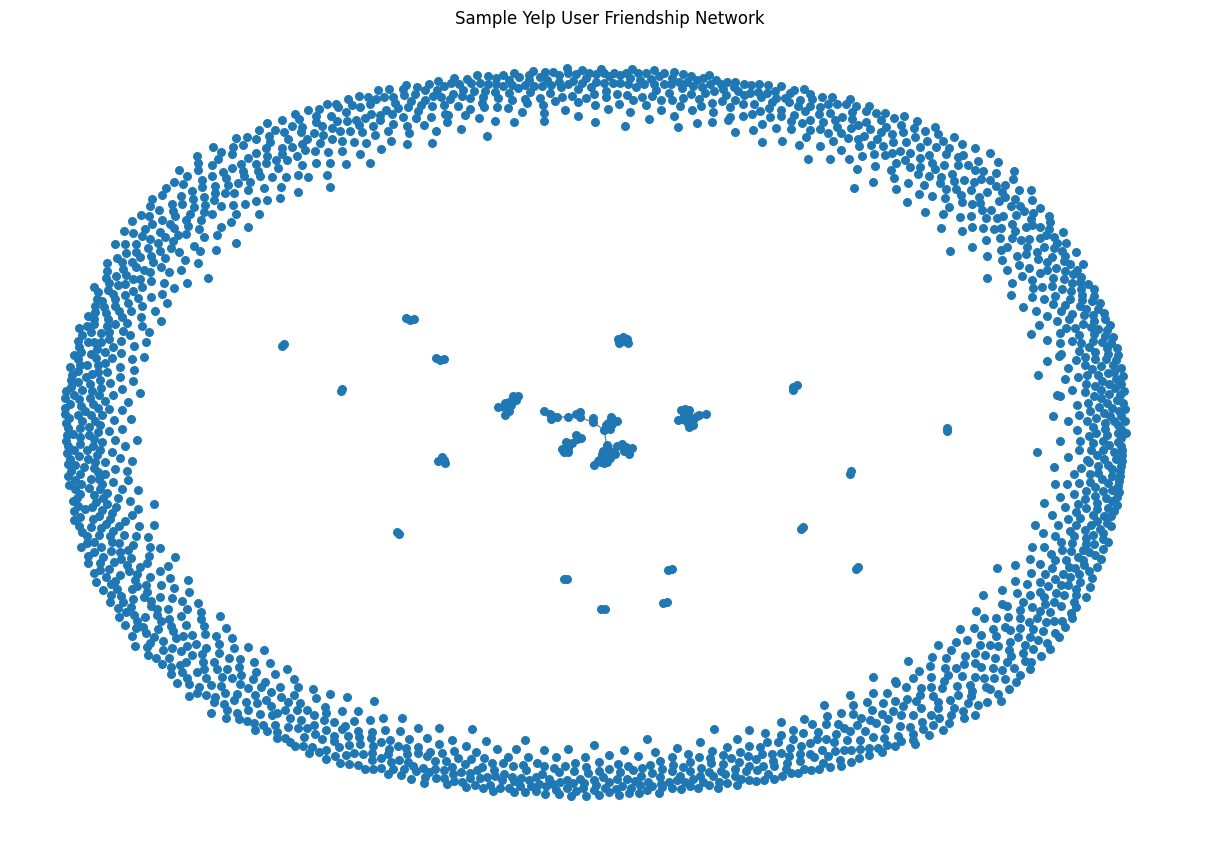

In [22]:
sample_nodes = list(G.nodes)[:2000]
subgraph = G.subgraph(sample_nodes)

plt.figure(figsize=(12, 8))
nx.draw(subgraph, with_labels=False, node_size=30, edge_color='gray')
plt.title("Sample Yelp User Friendship Network")
plt.show()

### Degree Centrality Measures

In [23]:
degree_centrality = nx.degree_centrality(G)
merged_df['centrality_degree'] = merged_df['user_id'].map(degree_centrality)
closeness_centrality = nx.closeness_centrality(G)
merged_df['centrality_closeness'] = merged_df['user_id'].map(closeness_centrality)
merged_df.head()

,review_id,user_id,business_id,stars,text,useful_review,funny_review,cool_review,date,name,review_count,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_cool,clean_text,neg,neu,pos,compound,neg,neu,pos,compound,friends_list,network_degree,centrality_degree,centrality_closeness
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",0,0,0,2018-07-07 22:09:11,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06,0,1,if you decide to eat here just be aware it is ...,0.000,0.890,0.110,0.8491,0.000,0.890,0.110,0.8491,"[DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWs...",1,0.000020,0.082124
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,1,0,1,2012-01-03 15:28:18,Erin,10,2011-03-07 19:45:15,6,1,2,,"7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTDQ...",0,4.30,0,0,ive taken a lot of spin classes over the years...,0.050,0.707,0.243,0.9855,0.050,0.707,0.243,0.9855,"[7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTD...",2,0.000040,0.073751
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,0,0,0,2014-02-05 20:30:30,Debra,1332,2012-09-04 23:57:25,1660,675,1300,"2014,2015,2016,2017,2018,2019,20,20,2021","IaqwLtG5Se-kt_MHBOalag, tBpyi-tXOYQlkjtQKPd5aw...",58,4.69,16,86,family diner had the buffet eclectic assortmen...,0.035,0.709,0.257,0.9201,0.035,0.709,0.257,0.9201,"[IaqwLtG5Se-kt_MHBOalag, tBpyi-tXOYQlkjtQKPd5a...",4,0.000079,0.103175
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",1,0,1,2015-01-04 00:01:03,Kyle,9,2014-01-17 19:20:57,1,0,1,,None,0,4.78,0,0,wow yummy different delicious our favorite is ...,0.000,0.674,0.326,0.9509,0.000,0.674,0.326,0.9509,[None],0,0.000000,0.000000
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,1,0,1,2017-01-14 20:54:15,Sophia,126,2008-04-17 13:39:54,74,20,12,,None,0,2.97,0,0,cute interior and owner gave us tour of upcomi...,0.017,0.710,0.272,0.9798,0.017,0.710,0.272,0.9798,[None],0,0.000000,0.000000


### Classification model with random forest, logistic regression and SVM

In [24]:
# target feature is_usful, based on if the userful review feature has 1 or more count
merged_df['is_useful'] = merged_df['useful_review'].apply(lambda x: 1 if x >= 1 else 0)
merged_df.head()

,review_id,user_id,business_id,stars,text,useful_review,funny_review,cool_review,date,name,review_count,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_cool,clean_text,neg,neu,pos,compound,neg,neu,pos,compound,friends_list,network_degree,centrality_degree,centrality_closeness,is_useful
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",0,0,0,2018-07-07 22:09:11,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06,0,1,if you decide to eat here just be aware it is ...,0.000,0.890,0.110,0.8491,0.000,0.890,0.110,0.8491,"[DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWs...",1,0.000020,0.082124,0
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,1,0,1,2012-01-03 15:28:18,Erin,10,2011-03-07 19:45:15,6,1,2,,"7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTDQ...",0,4.30,0,0,ive taken a lot of spin classes over the years...,0.050,0.707,0.243,0.9855,0.050,0.707,0.243,0.9855,"[7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTD...",2,0.000040,0.073751,1
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,Family diner. Had the buffet. Eclectic assortm...,0,0,0,2014-02-05 20:30:30,Debra,1332,2012-09-04 23:57:25,1660,675,1300,"2014,2015,2016,2017,2018,2019,20,20,2021","IaqwLtG5Se-kt_MHBOalag, tBpyi-tXOYQlkjtQKPd5aw...",58,4.69,16,86,family diner had the buffet eclectic assortmen...,0.035,0.709,0.257,0.9201,0.035,0.709,0.257,0.9201,"[IaqwLtG5Se-kt_MHBOalag, tBpyi-tXOYQlkjtQKPd5a...",4,0.000079,0.103175,0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",1,0,1,2015-01-04 00:01:03,Kyle,9,2014-01-17 19:20:57,1,0,1,,None,0,4.78,0,0,wow yummy different delicious our favorite is ...,0.000,0.674,0.326,0.9509,0.000,0.674,0.326,0.9509,[None],0,0.000000,0.000000,1
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,1,0,1,2017-01-14 20:54:15,Sophia,126,2008-04-17 13:39:54,74,20,12,,None,0,2.97,0,0,cute interior and owner gave us tour of upcomi...,0.017,0.710,0.272,0.9798,0.017,0.710,0.272,0.9798,[None],0,0.000000,0.000000,1


In [25]:
features = ['compound','review_count','average_stars','network_degree','centrality_degree','centrality_closeness']
X = merged_df[features].fillna(0)
y = merged_df['is_useful']

### train test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5664)

### random forest

In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=5664)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

### Logistic regression classifier

In [28]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

### SVC

In [29]:
svc_model = LinearSVC(max_iter=10000)
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

In [30]:
def get_metrics(model_name, y_true, y_pred):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

metrics = [
    get_metrics('Random Forest', y_test, y_pred_rf),
    get_metrics('Logistic Regression', y_test, y_pred_log),
    get_metrics('SVM (Linear)', y_test, y_pred_svc)
]

m = pd.DataFrame(metrics)
m

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.626583,0.542897,0.406974,0.465211
1,Logistic Regression,0.646250,0.633333,0.269785,0.378386
2,SVM (Linear),0.646500,0.614483,0.306536,0.409028


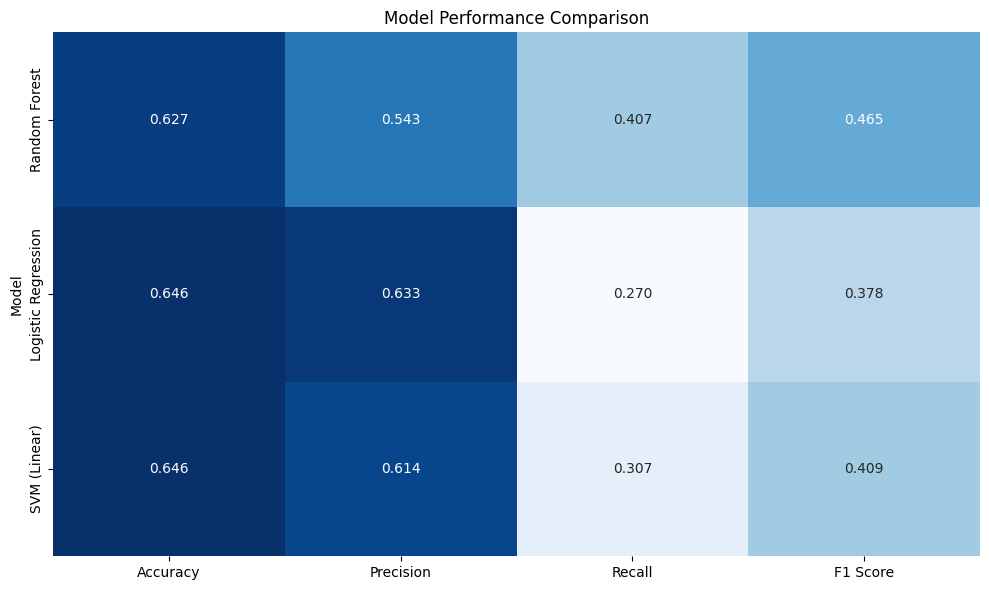

In [31]:
metrics_df = m.set_index("Model")

# Plot the metrics
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap="Blues", fmt=".3f", cbar=False)
plt.title("Model Performance Comparison")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

## Questions aiming to answer 

###     What kind of writing makes a review useful?

#### High compound score, a more uesfull review

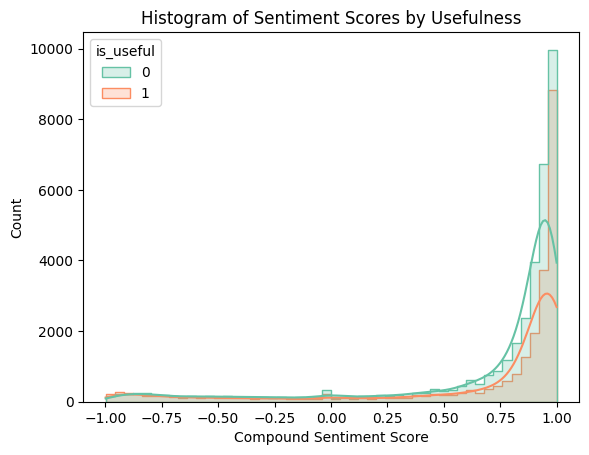

In [41]:
sns.histplot(data=merged_df, x='compound', hue='is_useful', kde=True, bins=50, palette='Set2',element='step')
plt.title("Histogram of Sentiment Scores by Usefulness")
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Count")
plt.show()

#### Review with longer length 

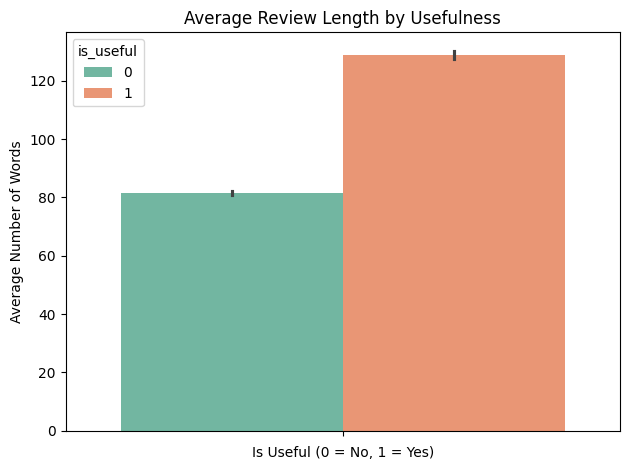

In [43]:
merged_df = merged_df.copy() 
merged_df['review_length'] = merged_df['clean_text'].apply(lambda x: len(x.split()))

plt.figure()
sns.barplot(data=merged_df, hue='is_useful', y='review_length', palette='Set2',legend=True)
plt.title("Average Review Length by Usefulness")
plt.xlabel("Is Useful (0 = No, 1 = Yes)")
plt.ylabel("Average Number of Words")
plt.tight_layout()
plt.show()

#### Does social network influence matters

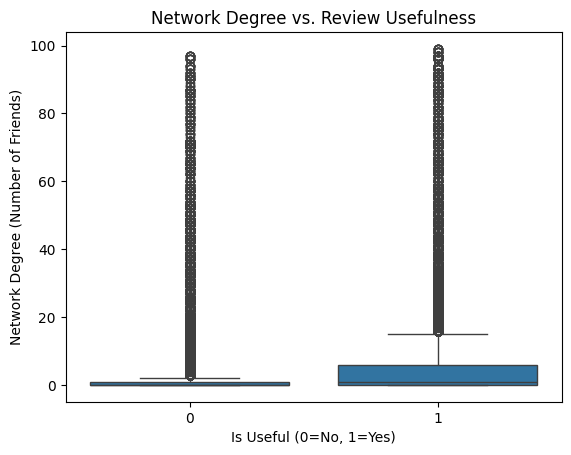

In [44]:
sns.boxplot(data=merged_df[merged_df['network_degree'] < 100], x='is_useful', y='network_degree')
plt.title("Network Degree vs. Review Usefulness")
plt.xlabel("Is Useful (0=No, 1=Yes)")
plt.ylabel("Network Degree (Number of Friends)")
plt.show()

In [45]:
merged_df[['is_useful', 'network_degree', 'centrality_closeness']].corr()

,is_useful,network_degree,centrality_closeness
is_useful,1.000000,0.146679,0.221533
network_degree,0.146679,1.000000,0.327903
centrality_closeness,0.221533,0.327903,1.000000


In [46]:
merged_df.to_csv('yelp_merged_final.csv', index=False)